# Estimating betas

#### Author: Gustavo Soares

## Introduction

The SDF framework gave us the so called **beta representation**:

$$
E_{t}[R^{e}_{i,t+1}] = \alpha_{i,t} + \beta_{i,t}´\lambda_{t}
$$

If markets are efficient under that particular asset pricing model, then we should have $\alpha_{i,t} = 0$. We therefore can use data to test if $\alpha_{i,t} = 0$ or not. If we find that $\alpha_{i,t} \neq 0$, then we have found an **anomaly**. However, we also discussed how we need to be careful with the interpretation of the term **anomaly** because of the **join-hypothesis problem**. The **anomaly**, $\alpha_{i,t} \neq 0$, is only evidence that the market is inefficient if our model is correct. However, under an expanded, enhanced or enriched market equilibrium model that anomaly may not be an anomaly at all and we may go back to $\alpha_{i,t} = 0$ if we use a different model.

The Capital Asset Pricing Model (CAPM) from [Sharpe (1964)](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1540-6261.1964.tb02865.x) is the first and most famous asset pricing factor model. Where the $k \times 1$ random vector of time-varying factors $f_{t}$ is actually a single scalar and equal to the excess returns of the so-called **market portfolio**, $R^{M}_{t}$. In the CAPM, we also assume that the beta to the market portfolio is constant over time, i.e., $\beta_{i,t}=\beta_{i}$ and can be estimated by running a time-series regressing of the excess returns $R^{e}_{i,t+1}$ of asset $i$, or the returns of a portfolio of assets, onto the market portfolio factors $R^{M}_{t+1}$ over $t=1,\dots,T$:

$$
R^{e}_{i,t} = \alpha_{i} + \beta_{i}R^{M}_{t} + \epsilon_{i,t}
$$

Over long periods of time, we would expect that asset $i$ with high $\beta_{i}$ outperforms assets $j$ with low $\beta_{j}$.

## Estimating beta

In this section, we introduce several different ways of estimating beta, all of which are based on regressions of a stock’s excess returns on the excess returns of the market portfolio.

Let's start by importing what we need and grabbing the data on the Ibovespa index, the CDI rate which is our risk-free rate, and on the total return of each of the Ibovespa index components:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader as pdr
tr_df = pd.read_csv('tr_df.csv', index_col=[0,1]).iloc[:,0].unstack().T.astype(float)
tr_df.index = pd.to_datetime(tr_df.index)
df = pd.read_csv('IBOV_time_series.csv', index_col=0).astype(float)
df.index = pd.to_datetime(df.index)

### Excess returns

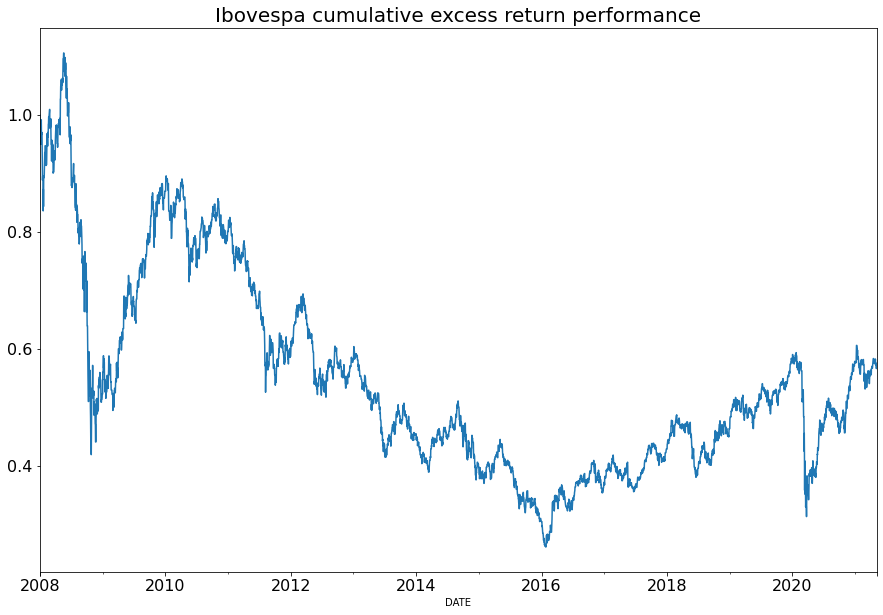

In [2]:
ibov = np.log(df['Ibov']).diff(1) - np.log(df['CDI']).diff(1)
np.exp(ibov.fillna(0).cumsum()).plot(figsize=(15,10), fontsize=16)
plt.title('Ibovespa cumulative excess return performance', fontsize=20)
plt.show()

In [3]:
er_df = pd.concat([tr_df, df[['CDI']]],
                  axis=1, join='outer', sort=True).fillna(method='ffill').dropna()
er_df = np.log(er_df).diff(1).subtract(np.log(er_df['CDI']).diff(1), axis=0).drop('CDI', 1)

### Linear regressions

In most cases, market beta is estimated using only data from periods prior to and including period t. A common approach is to estimate the regression above using one year’s worth of daily excess return data. At each month end, regress the data using daily return data from the 12-month period covering months t − 11 through t, inclusive. A minimum number of data points are usually required to ensure the quality of the values estimated by the regression. In the case of daily data over a one-year period, a reasonable requirement may be that the regression be fit using at least 252 data points. Let's try that:

In [4]:
month_ends = [er_df.index[i-1] for i in range(1, er_df.shape[0]) 
                                          if er_df.index[i].month != er_df.index[i-1].month]
month_ends += [er_df.index[-1]]
pooled_data = pd.DataFrame()
for t in month_ends:
    YX = er_df.rolling(252, min_periods=252).sum().loc[t]
    YX['mkt'] = ibov.rolling(252, min_periods=252).sum().loc[:t].iloc[-1]
    pooled_data = pooled_data.append(YX.dropna().to_frame(t).T)

betas = pd.DataFrame()
for i in range(pooled_data.shape[1]-1):  
    yx = pooled_data.iloc[:,[i,-1]].dropna()
    model = sm.OLS(yx.iloc[:,0],sm.add_constant(yx.iloc[:,-1])).fit()    
    coef = model.params.to_frame(pooled_data.columns[i]).T
    betas = betas.append(coef)

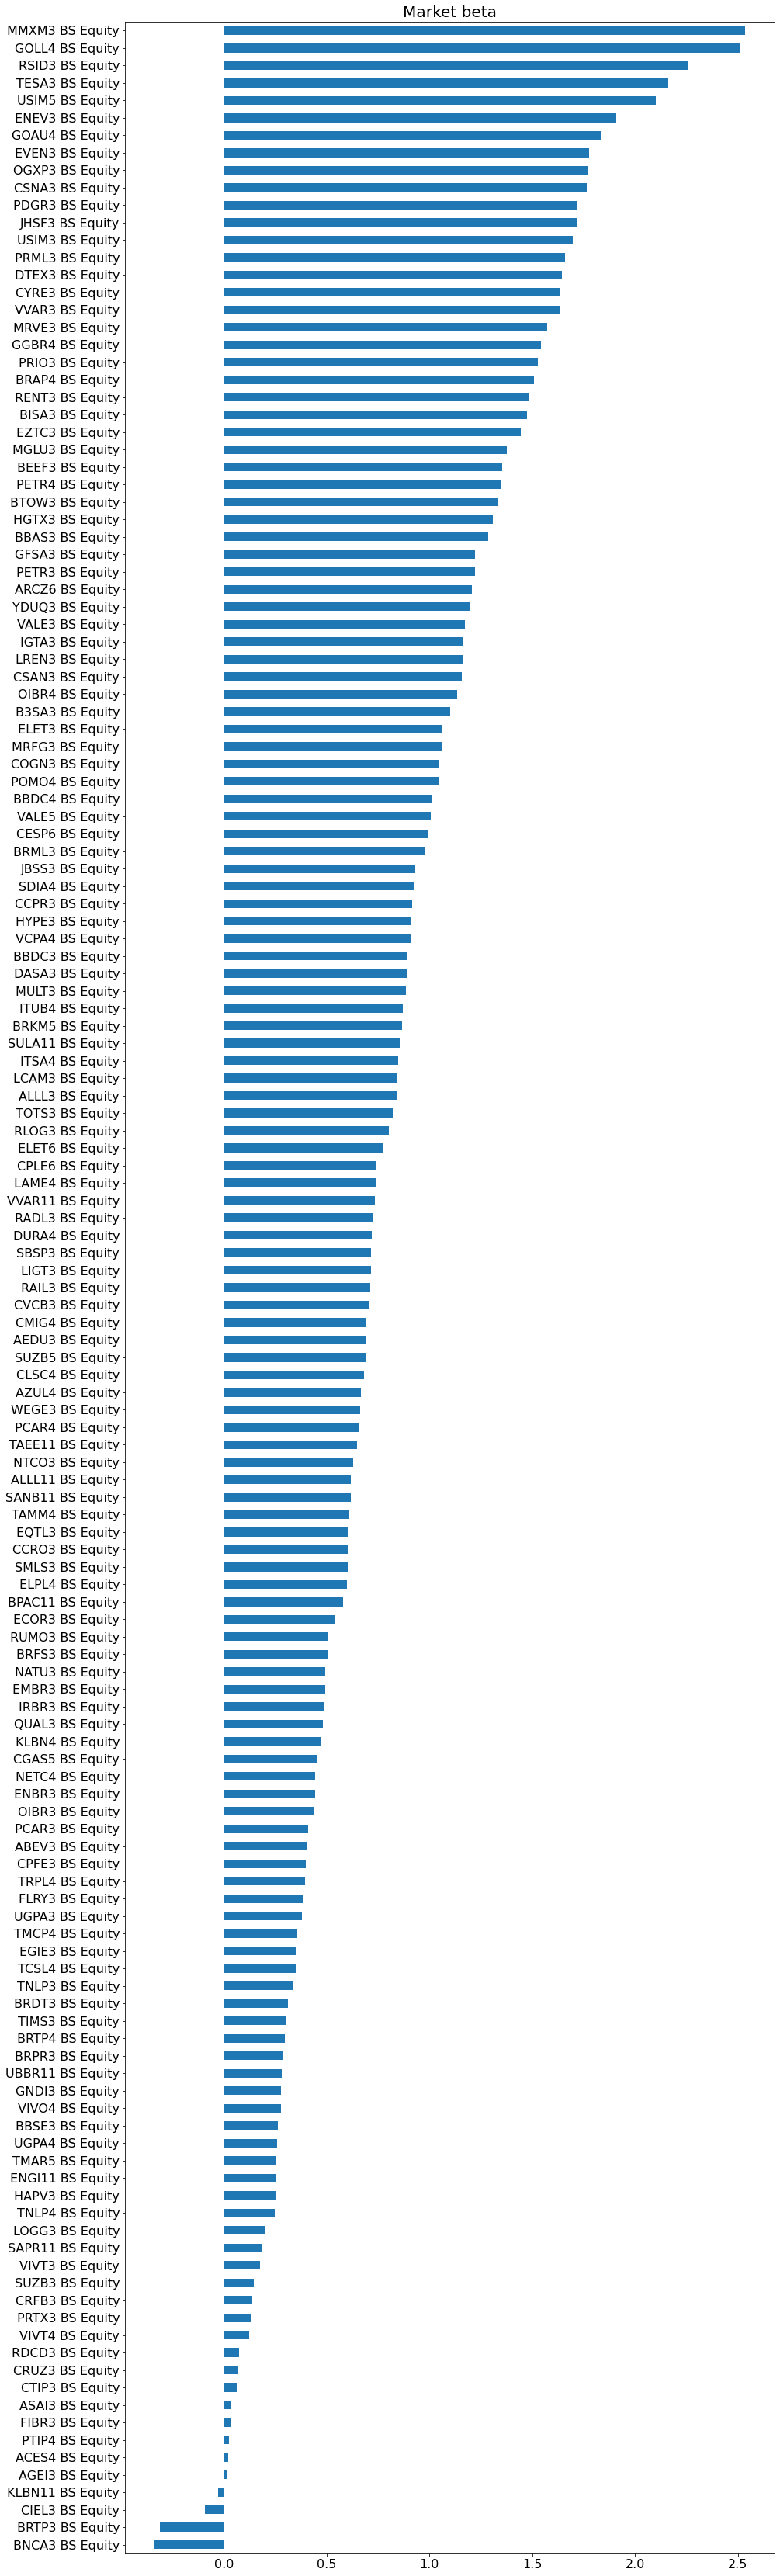

In [5]:
betas.iloc[:,1].sort_values().plot(kind='barh', figsize=(15,60), fontsize=16)
plt.title('Market beta', fontsize=20)
plt.show()

In [6]:
betas.describe()

,const,mkt
count,145.000000,145.000000
mean,-0.008132,0.805032
std,0.082022,0.576450
min,-0.368590,-0.335871
25%,-0.039641,0.378492
50%,-0.003573,0.713870
75%,0.035713,1.160622
max,0.191423,2.534805


While using one year’s worth of daily data to calculate beta is common, other estimation period lengths and data frequencies are also used. Another common approach is to use monthly excess return data from the past five years. Let's try that:

In [7]:
monthly_er_df = np.log(np.exp(er_df.fillna(0).cumsum()).resample('M').last()).diff(1)
monthly_ibov = np.log(np.exp(ibov.fillna(0).cumsum()).resample('M').last()).diff(1)

pooled_data = pd.DataFrame()
for t in monthly_er_df.index:
    YX = monthly_er_df.rolling(5 * 12, min_periods=5 * 12).sum().loc[t]
    YX['mkt'] = monthly_ibov.rolling(5 * 12, min_periods=5 * 12).sum().loc[:t].iloc[-1]
    pooled_data = pooled_data.append(YX.dropna().to_frame(t).T)

betas2 = pd.DataFrame()
for i in range(pooled_data.shape[1]-1):  
    yx = pooled_data.iloc[:,[i,-1]].dropna()
    model = sm.OLS(yx.iloc[:,0],sm.add_constant(yx.iloc[:,-1])).fit()    
    coef = model.params.to_frame(pooled_data.columns[i]).T
    betas2 = betas2.append(coef)

In [8]:
betas2.describe()

,const,mkt
count,145.000000,145.000000
mean,-0.140334,0.724862
std,0.725561,1.154594
min,-3.694251,-2.296930
25%,-0.400813,0.066153
50%,-0.077684,0.490880
75%,0.219236,1.267506
max,2.300525,6.222757


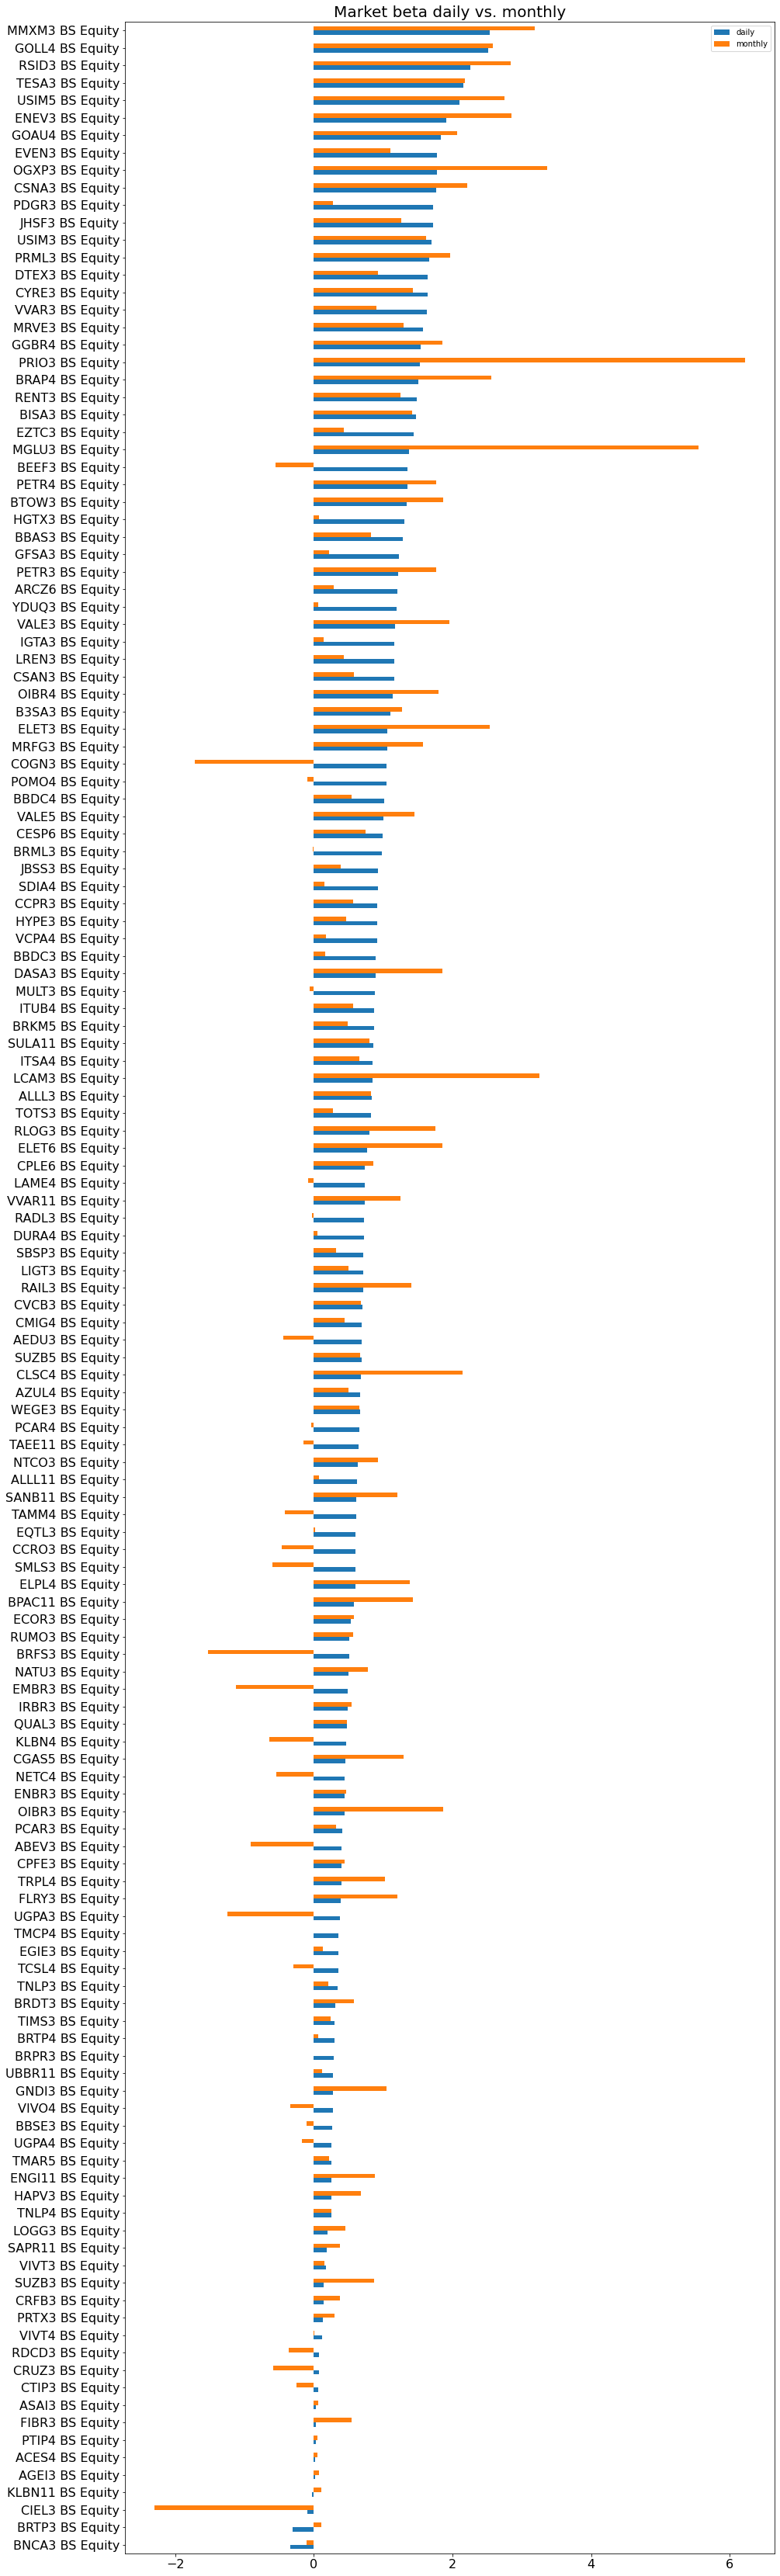

In [9]:
betas3 = pd.concat([betas.iloc[:,1].to_frame('daily'),
                   betas2.iloc[:,1].to_frame('monthly')], axis=1, sort=False).sort_values(by='daily')
betas3.plot(kind='barh', figsize=(15,60), fontsize=16)
plt.title('Market beta daily vs. monthly', fontsize=20)
plt.show()

### Rolling regressions

In practice, betas tend to vary over time. Rolling regression are a way to see how an asset beta evolves over time. Let's look at two examples, ENEV3 and ITSA4:

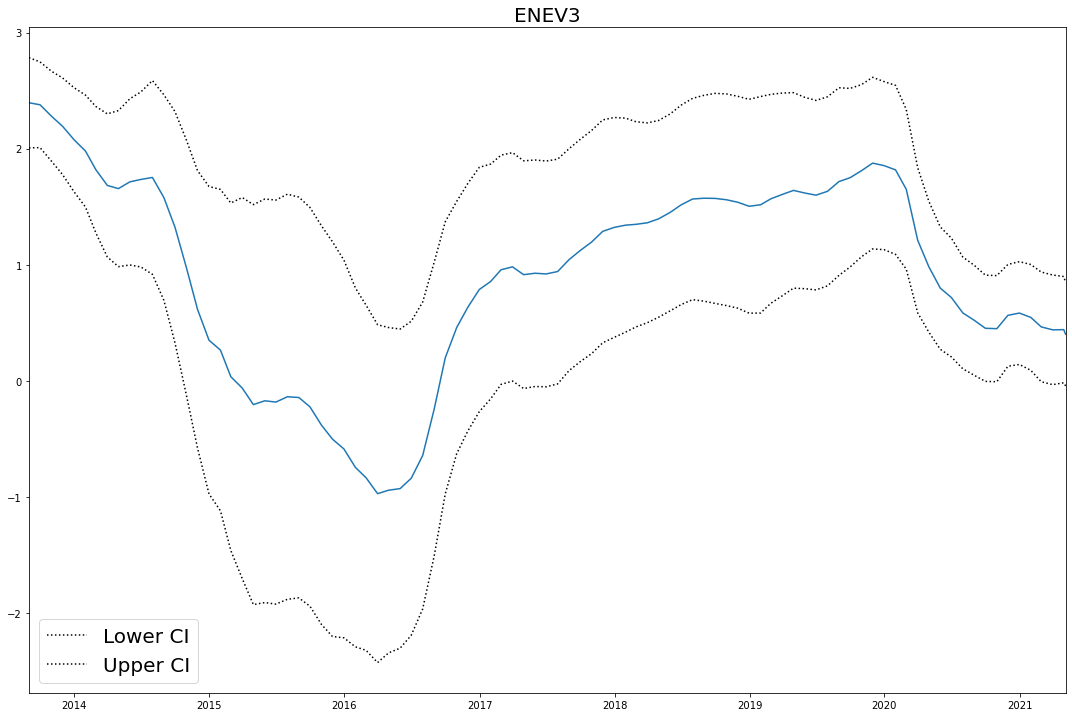

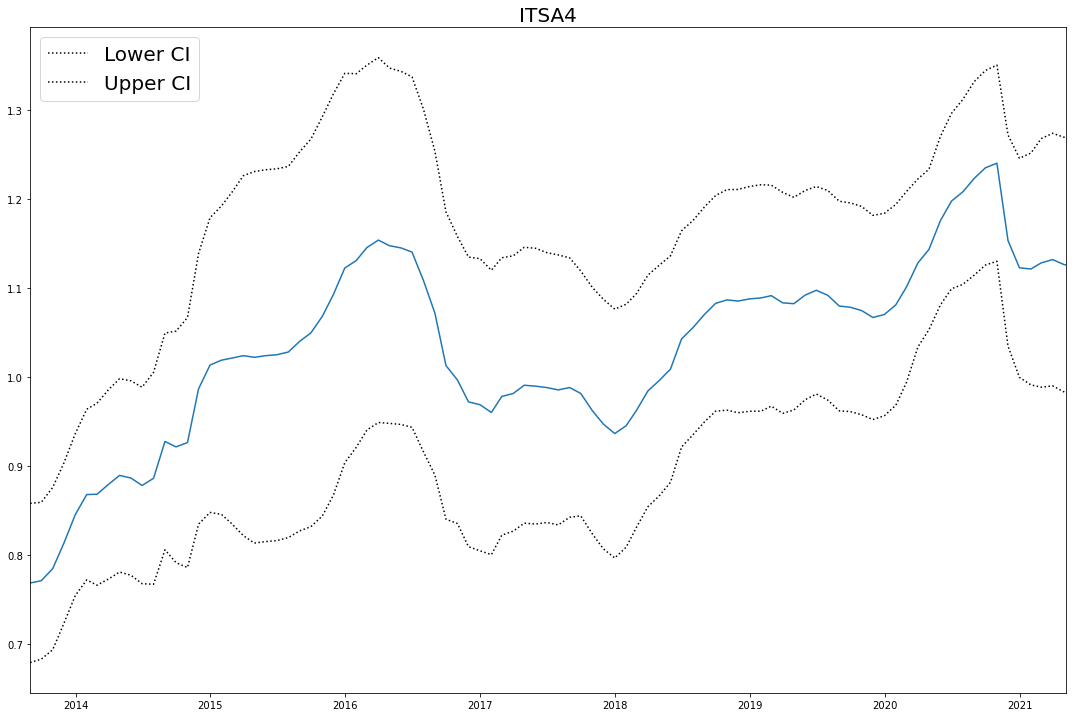

In [10]:
month_ends = [er_df.index[i-1] for i in range(1, er_df.shape[0]) 
                                          if er_df.index[i].month != er_df.index[i-1].month]
month_ends += [er_df.index[-1]]
pooled_data = pd.DataFrame()
for t in month_ends:
    YX = er_df.rolling(252, min_periods=252).sum().loc[t]
    YX['mkt'] = ibov.rolling(252, min_periods=252).sum().loc[:t].iloc[-1]
    pooled_data = pooled_data.append(YX.dropna().to_frame(t).T)

for s in ['ENEV3', 'ITSA4']:
    yx = pooled_data.loc[:,[s +  ' BS Equity', 'mkt']].dropna()    
    rols = RollingOLS(yx.iloc[:,0],
                      sm.add_constant(yx.iloc[:,1]),
                      window=60)
    rres = rols.fit()
    params = rres.params
    rres.plot_recursive_coefficient(variables=['mkt'], figsize=(15,10))
    plt.title(s, fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

### Beta by scenario

It's common for beta to vary a lot by scenario as well. Let's take a look at good and bad scenarios:

In [11]:
betas_by_scenario = pd.DataFrame()
for i in range(pooled_data.shape[1]-1):  
    yx = pooled_data.iloc[:,[i,-1]].dropna()
    model = sm.OLS(yx.iloc[:,0],sm.add_constant(yx.iloc[:,-1])).fit()
    avg_beta = model.params['mkt']
    bad_scenarios = yx[yx['mkt']<yx['mkt'].quantile(q=0.25)]
    model = sm.OLS(bad_scenarios.iloc[:,0],sm.add_constant(bad_scenarios.iloc[:,-1])).fit()
    bad_beta = model.params['mkt']
    good_scenarios = yx[yx['mkt']>yx['mkt'].quantile(q=0.75)]
    model = sm.OLS(good_scenarios.iloc[:,0],sm.add_constant(good_scenarios.iloc[:,-1])).fit()
    good_beta = model.params['mkt']        
    coef = pd.Series(index=['avg', 'bad', 'good'],
                     data=[avg_beta, bad_beta, good_beta]).to_frame(pooled_data.columns[i]).T
    betas_by_scenario = betas_by_scenario.append(coef)

In [12]:
betas_by_scenario[betas_by_scenario['avg']>1].describe()

,avg,bad,good
count,46.000000,46.000000,46.000000
mean,1.496367,1.650731,1.518489
std,0.386310,1.141291,0.846040
min,1.005681,-1.256486,-0.623695
25%,1.178536,1.109783,1.215898
50%,1.458338,1.594335,1.412795
75%,1.711090,2.338817,1.859080
max,2.534805,4.089047,3.712285


In [13]:
betas_by_scenario[betas_by_scenario['avg']<1].describe()

,avg,bad,good
count,99.000000,99.000000,99.000000
mean,0.483806,0.487803,0.324188
std,0.301932,0.747417,0.608630
min,-0.335871,-1.469009,-1.271369
25%,0.271067,-0.010938,-0.119960
50%,0.491946,0.377479,0.292964
75%,0.716537,0.909457,0.781174
max,0.993346,2.776981,1.715017


### Beta shrinkage

One of the key arguments against taking historical betas at face value is their instability over time and across good and bad scenarios. A potential solution is to [shrink the covariance matrix](https://scikit-learn.org/stable/modules/covariance.html#shrunk-covariance) using a technique such as [Ledoit-Wolf’s approach](http://www.ledoit.net/honey.pdf).

In practice, shrinkage boils down to a convex transformation, combining the empirical $\hat\beta$ with a prior $\beta$ using a shrinkage parameter $\delta$ which takes values between zero and one:

$$
\beta_{shrunk} = \delta \hat\beta + (1-\delta)\beta
$$


To illustrate, let's use shrinkage parameter equal to 0.5 and look at the case we estimate beta using a fast window and with a slow window:

In [14]:
delta = 0.5
betas_shrinkage = pd.DataFrame()
for i in range(pooled_data.shape[1]-1):  
    yx = pooled_data.iloc[:,[i,-1]].dropna()
    model = sm.OLS(yx.iloc[:,0], sm.add_constant(yx.iloc[:,-1])).fit()
    slow_beta = model.params['mkt']
    model = sm.OLS(yx.iloc[-63:,0], sm.add_constant(yx.iloc[-63:,-1])).fit()
    fast_beta = model.params['mkt']
    shrunk_beta = delta * slow_beta + (1 - delta) * fast_beta
    coef = pd.Series(index=['slow', 'fast', 'shrunk'],
                     data=[slow_beta, fast_beta, shrunk_beta]).to_frame(pooled_data.columns[i]).T
    betas_shrinkage = betas_shrinkage.append(coef)

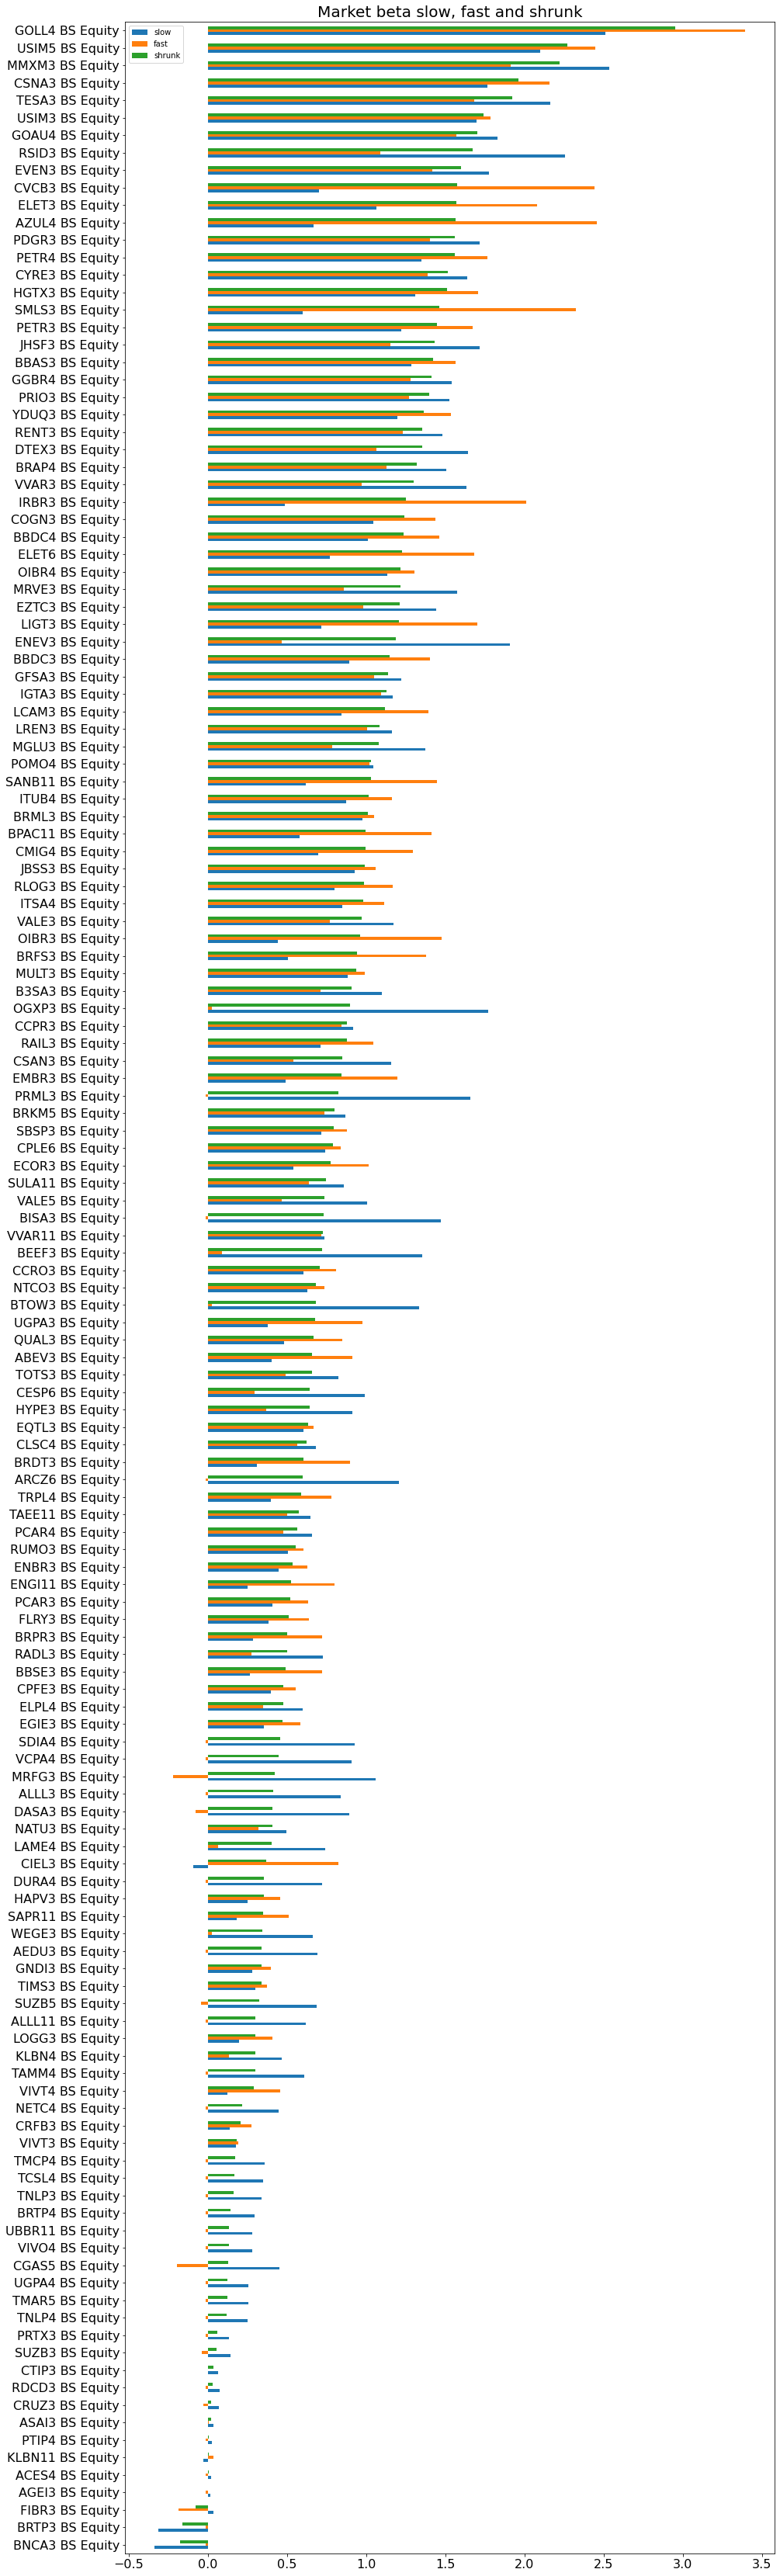

In [15]:
betas_shrinkage.sort_values(by='shrunk').plot(kind='barh', figsize=(15,60), fontsize=16)
plt.title('Market beta slow, fast and shrunk', fontsize=20)
plt.show()